In [1]:
#Setup
# set this to your working directory
WORKING_DIR = '/home/elliott/Dropbox/_Ash_Teaching/2018-09 - Bocconi - Text Data and ML/code'
import os
os.chdir(WORKING_DIR)
import matplotlib.pyplot as plt
%matplotlib notebook
import pandas as pd
df1 = pd.read_csv('death-penalty-cases.csv')
df1['snippet'] = df1['snippet'].str.replace('hellip',' ').str.replace('\d+',' ')
state = df1['state']

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english',
                             max_features=500)
X = vectorizer.fit_transform(df1['snippet']).todense()
X = X / X.sum(axis=1) # counts to frequencies
for i, word in enumerate(vectorizer.get_feature_names()):
    column = X[:,i]
    df1['x_'+word] = column

import numpy as np
df1['logcites'] = np.log(1+df1['citeCount'])

features = [x for x in df1.columns if x.startswith('x_')]
keepcols = ['logcites'] + features
df1 = df1[keepcols]

df1['any_cites'] = df1['logcites'] > 0
y = df1['any_cites']

from sklearn.model_selection import train_test_split
train, test = train_test_split(df1, test_size=0.2)
features = [x for x in df1.columns if x.startswith('x_')]

In [2]:
# Binary Classifier
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=10) 
sgd_clf.fit(train[features], train['any_cites'])
sgd_clf.score(test[features],test['any_cites']) # accuracy on held-out data

0.74270801350936444

In [3]:
# compare to picking largest category
df1['any_cites'].mean()

0.73159947185801577

In [4]:
# Form cross-validated prdictions for all data points
from sklearn.model_selection import cross_val_predict
df1['any_cites_sgd'] = cross_val_predict(sgd_clf,
                                         df1[features],
                                         df1['any_cites'],
                                         cv=3,
                                         n_jobs=3)

In [5]:
# Construction confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(df1['any_cites'], df1['any_cites_sgd'])

array([[ 1308,  7433],
       [ 1615, 22211]])

In [6]:
# Precision and Recall
from sklearn.metrics import precision_score, recall_score
print('Precision:',precision_score(df1['any_cites'], df1['any_cites_sgd']))
print('Recall:',recall_score(df1['any_cites'], df1['any_cites_sgd']))

Precision: 0.749257859938
Recall: 0.932216905901


In [7]:
#F1 score
from sklearn.metrics import f1_score
f1_score(df1['any_cites'], df1['any_cites_sgd'])

0.83078361698148495

(array([   256.,    221.,     29.,    141.,    300.,    471.,   1353.,
          8900.,  20606.,    290.]),
 array([-1.31003671, -1.01442804, -0.71881936, -0.42321069, -0.12760202,
         0.16800665,  0.46361532,  0.759224  ,  1.05483267,  1.35044134,
         1.64605001]),
 <a list of 10 Patch objects>)

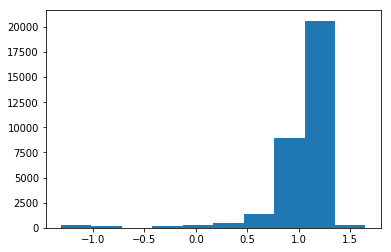

In [8]:
##############
# Precision/Recall Trade Off
##############
# scores used by SGDClassifier
y_scores = sgd_clf.decision_function(df1[features])
plt.hist(y_scores) # histogram of scores

In [9]:
# prediction using default threshold ... 
threshold = 0
(y_scores > threshold).mean()

0.97730831823625142

In [10]:
# ... gives default model prediction
ypred = sgd_clf.predict(df1[features])
ypred.mean()

0.97730831823625142

In [11]:
# increasing threshold means more zeros are predicted
threshold = 1
(y_scores > threshold).mean()

0.75622562716860631

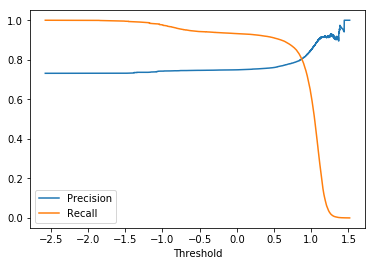

In [12]:
# Visualizing the precision/recall tradeoff
y_scores = cross_val_predict(sgd_clf,
                             df1[features],
                             df1['any_cites'],
                             cv=3,
                             method='decision_function',
                             n_jobs=3)

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(df1['any_cites'], y_scores)

import matplotlib.pyplot as plt
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel('Threshold')
plt.legend()

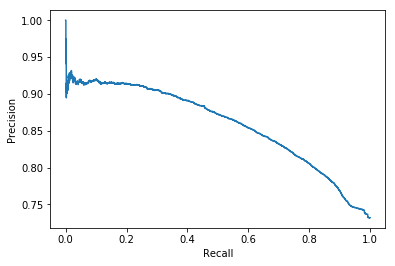

In [13]:
# Plot precisions vs recall
plt.step(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')

In [14]:
# Assessing other scoring thresholds
ypred_lower = y_scores > -1
ypred_higher = y_scores > 1

print('Precision for Low Threshold:',precision_score(y, ypred_lower))
print('Precision for High Threshold:',precision_score(y, ypred_higher))
print('Recall for Low Threshold:',recall_score(y, ypred_lower))
print('Recall for High Threshold:',recall_score(y, ypred_higher))

Precision for Low Threshold: 0.742827051352
Precision for High Threshold: 0.851030569708
Recall for Low Threshold: 0.97687400319
Recall for High Threshold: 0.61693108369


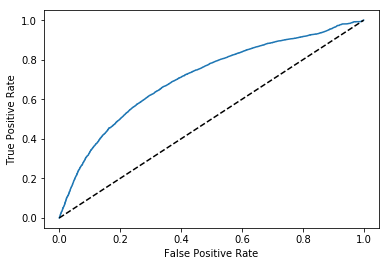

In [15]:
# ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y, y_scores)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [16]:
# AUC
from sklearn.metrics import roc_auc_score
roc_auc_score(y, y_scores)

0.7090811243506806

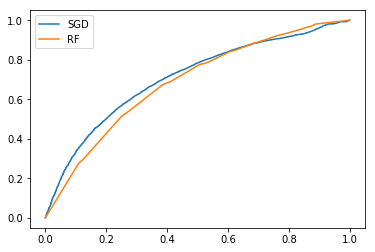

In [17]:
# Random Forests and predict_proba()
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
y_probas_rfc = cross_val_predict(rfc,
                                 X,
                                 y,
                                 cv=3,
                                 method='predict_proba',
                                 n_jobs=3)

y_scores_rfc = y_probas_rfc[:,1]
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y,y_scores_rfc) 

# compare precision/recall tradeoff for SGD and RF classifiers
plt.plot(fpr, tpr, label="SGD")
plt.plot(fpr_rfc, tpr_rfc, label="RF")
plt.legend()

In [18]:
roc_auc_score(y,y_scores_rfc)

0.68594512816785291

In [23]:
###
# Multinomial CLassification
###
statepred = cross_val_predict(sgd_clf,
                              X,
                              state,
                              cv=3)
print((statepred == state).mean())
list(zip(state[:8],statepred[:8]))

/home/elliott/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


0.353333128627


[('NJ', 'AL'),
 ('FL', 'FL'),
 ('TX', 'TX'),
 ('NM', 'AL'),
 ('TX', 'GA'),
 ('AZ', 'RI'),
 ('NM', 'AL'),
 ('TN', 'WI')]

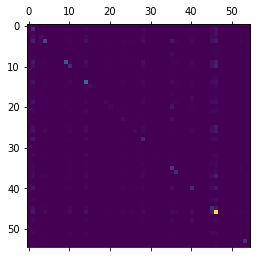

In [24]:
# Multi-class confusion matrix
conf_mx = confusion_matrix(state,statepred)
conf_mx
plt.matshow(conf_mx)

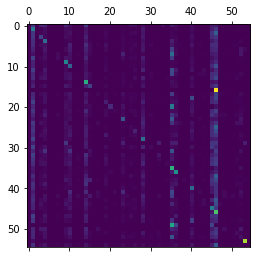

In [25]:
# normalize colors
conf_mx_norm = conf_mx / conf_mx.sum(axis=1, keepdims=True)
plt.matshow(conf_mx_norm)